In [21]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

df = pd.read_excel('election_results_1918_2017.xlsx')
df = df[df['election']>1970]

nat = ['natSW_votes','natSW_share','oth_votes','oth_share']
for i in nat:
    df[i].fillna(0,inplace=True)
    
df['winner'] = df[['con_votes','lib_votes','lab_votes','natSW_votes','oth_votes']].idxmax(axis=1).str[:3]

df.head()

,constituency_id,seats,constituency,country/region,electorate,con_votes,con_share,lib_votes,lib_share,lab_votes,lab_share,natSW_votes,natSW_share,oth_votes,oth_share,total_votes,turnout,election,boundary_set,winner
9278,1.0,1,ABERAVON,Wales,64162.0,10968.0,0.23,NaN,NaN,31656.0,0.65,5898.0,0.12,0.0,0,48522.0,0.756,1974.0,1974-1979,lab
9279,2.0,1,ABERDARE,Wales,48026.0,3169.0,0.08,NaN,NaN,23805.0,0.60,11973.0,0.30,1038.0,0.026,39985.0,0.833,1974.0,1974-1979,lab
9280,3.0,1,ABERDEEN NORTH,Scotland,64349.0,8115.0,0.17,6001.0,0.12,23193.0,0.48,11337.0,0.23,0.0,0,48646.0,0.756,1974.0,1974-1979,lab
9281,4.0,1,ABERDEEN SOUTH,Scotland,67379.0,21938.0,0.40,7447.0,0.13,18380.0,0.33,7599.0,0.14,0.0,0,55364.0,0.822,1974.0,1974-1979,con
9282,5.0,1,ABERDEENSHIRE EAST,Scotland,47147.0,12634.0,0.35,2727.0,0.08,2416.0,0.07,18333.0,0.51,0.0,0,36110.0,0.766,1974.0,1974-1979,nat


In [38]:
data = pd.DataFrame(index=pd.MultiIndex.from_product([df['election'].unique(),['con','lib','lab','nat']],names=['year','party']))

data['seats'] = df.groupby(['election','winner']).count()['seats']
data['seats'].fillna(0,inplace=True)

votes = pd.DataFrame(index=df['election'].unique(),columns=['con','lib','lab','nat'])
for i in ['con_votes','lib_votes','lab_votes','natSW_votes']:
    votes.loc[:,i[:3]] = df.groupby('election').sum().loc[:,i]
    
var = pd.DataFrame(index=df['election'].unique(),columns=['con','lib','lab','nat'])
for i in ['con_votes','lib_votes','lab_votes','natSW_votes']:
    var[i[:3]] = df.groupby('election').std()[i]/df.groupby('election').mean()[i]
    
data['votes'] = votes.stack()
data = data/data.groupby(level=0).sum()
data['cv'] = var.stack()
data['rep'] = (data['seats']/data['votes']).replace([np.inf,0],[np.nan,np.nan])-1
data['rank'] = data.reset_index().groupby('year')['votes'].rank(ascending=False).values
data['first'] = (data['rank']==1).astype(int)
data['second'] = (data['rank']==2).astype(int)
data['size'] = (data['first'] + data['second']).replace([1,0],['big','small']).astype('category').cat.reorder_categories(['small', 'big'])
data.head()

seats     votes        cv       rep  rank  first  second  \
year   party                                                                
1974.0 con    0.477419  0.390071  0.396311  0.223930   1.0      1       0   
       lib    0.022581  0.199728  0.429669 -0.886943   3.0      0       0   
       lab    0.485484  0.383703  0.422788  0.265261   2.0      0       1   
       nat    0.014516  0.026498  2.713156 -0.452190   4.0      0       0   
1974.5 con    0.444623  0.370114  0.452393  0.201314   2.0      0       1   

               size  
year   party         
1974.0 con      big  
       lib    small  
       lab      big  
       nat    small  
1974.5 con      big

In [41]:
import statsmodels.formula.api as smf

res = smf.ols('rep ~ votes*cv',data).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    rep   R-squared:                       0.710
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     35.85
Date:                Sat, 28 Dec 2019   Prob (F-statistic):           6.98e-12
Time:                        09:06:57   Log-Likelihood:                -1.5582
No. Observations:                  48   AIC:                             11.12
Df Residuals:                      44   BIC:                             18.60
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.9880      0.205     -9.690      0.000      -2.401      -1.575
votes          3.7624      0.684      5.504      0.000       2.385       5.140
cv             0.4729      0.074      6.353      0.000       0.323       0.623
votes:cv       2.5687      1.570      1.637      0.109      -0.594       5.732
==============================================================================
Omnibus:                       12.273   Durbin-Watson:                   2.503
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               12.975
Skew:                           1.013   Prob(JB):                      0.00152
Kurtosis:                       4.545   Cond. No.                         75.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

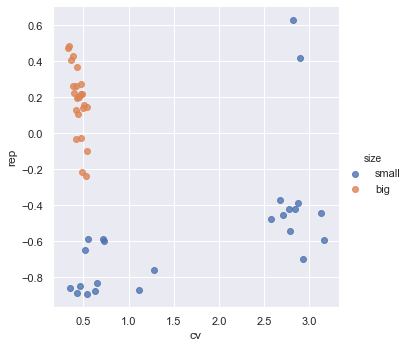

In [40]:
sns.lmplot(x='cv',y='rep',hue='size',data=data,fit_reg=False)

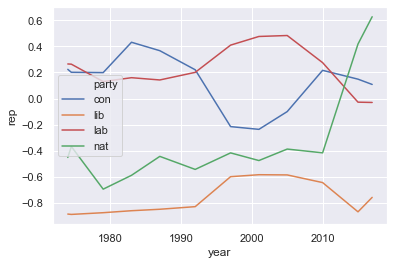

In [36]:
data1 = data.reset_index()

sns.lineplot(x='year',y='rep',hue='party',data=data1,palette=['C0','C1','C3','C2'])

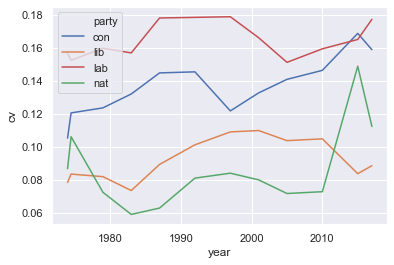

In [37]:
sns.lineplot(x='year',y='cv',hue='party',data=data1,palette=['C0','C1','C3','C2'])